In [19]:
%pip install -q pandas seaborn matplotlib



import pandas as pd

import seaborn as sns

from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\EXTECH\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
# use raw strings

files = {

    "breast": r"F:\DisEase-o-Meter\dataset\breast_cancer_cleaned.csv",

    "diabetes": r"F:\DisEase-o-Meter\dataset\diabetes_cleaned.csv",

    "kidney": r"F:\DisEase-o-Meter\dataset\kidney_disease_cleaned.csv",

    "heart": r"F:\DisEase-o-Meter\dataset\dataR2_cleaned.csv",

}

base = Path(r"F:/DisEase-o-Meter/dataset")

fnames = {

    "breast": "breast_cancer_cleaned.csv",

    "diabetes": "diabetes_cleaned.csv",

    "kidney": "kidney_disease_cleaned.csv",

    "heart": "dataR2_cleaned.csv",

}

dfs = {}

for k, fname in fnames.items():

    p = base / fname

    if not p.exists():

        # try to find any file matching the stem under `base`

        stem = Path(fname).stem

        matches = list(base.rglob(f"*{stem}*"))

        if matches:

            p = matches[0]

            print(f"Found file for '{k}' via glob: {p}")

        else:
            alt = files.get(k)

            if alt:

                p_alt = Path(alt)

                if not p_alt.exists():

                    p_alt = Path(alt.replace("\\", "/"))

                if p_alt.exists():

                    p = p_alt

                    print(f"Using alternative path for '{k}': {p}")

                else:

                    print(f"Warning: could not find file for '{k}' (tried {p} and {alt}). Creating empty DataFrame.")

                    dfs[k] = pd.DataFrame()

                    continue

            else:

                print(f"Warning: could not find file for '{k}' (tried {p}). Creating empty DataFrame.")

                dfs[k] = pd.DataFrame()

                continue

    try:

        dfs[k] = pd.read_csv(p)

    except Exception as e:

        print(f"Warning: failed to read '{p}' for '{k}': {e}. Creating empty DataFrame.")

        dfs[k] = pd.DataFrame()

In [13]:
# Drop known empty column in breast if fully NaN

if "Unnamed: 32" in dfs["breast"].columns and dfs["breast"]["Unnamed: 32"].isna().all():

    dfs["breast"].drop(columns=["Unnamed: 32"], inplace=True)

# Shapes and previews

for k, df in dfs.items():

    print(f"{k}: shape={df.shape}")

    display(df.head(3))

breast: shape=(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


kidney: shape=(400, 26)


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,normal,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,normal,normal,notpresent,notpresent,...,38,6000,5.2,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,5.2,no,yes,no,poor,no,yes,ckd


heart: shape=(116, 10)


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1


In [14]:
# Decide kidney target

def kidney_label(df):

    if "classification" in df.columns: return "classification"

    if "cad" in df.columns: return "cad"

    return None



targets = {

    "breast": "diagnosis",

    "diabetes": "Outcome",

    "heart": "Classification",

    "kidney": kidney_label(dfs["kidney"])

}

print("Kidney target:", targets["kidney"])

# Class balance

for k, df in dfs.items():

    col = targets[k]

    if col and col in df.columns:

        print(f"{k} — {col} value counts:")

        print(df[col].value_counts(dropna=False), "\n")

Kidney target: classification
breast — diagnosis value counts:
diagnosis
B    357
M    212
Name: count, dtype: int64 

diabetes — Outcome value counts:
Outcome
0    500
1    268
Name: count, dtype: int64 

kidney — classification value counts:
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64 

heart — Classification value counts:
Classification
2    64
1    52
Name: count, dtype: int64 



In [15]:
# Missingness check

if "dfs" not in globals():

    print("Variable 'dfs' is not defined. Please run the data-loading cell (CELL INDEX 0) before this one.")

else:

    for name in ["breast", "diabetes", "heart", "kidney"]:

        df = dfs.get(name)

        print(f"=== {name.upper()} missing value report ===")

        if df is None:

            print(f"No dataframe for '{name}' (dfs.get returned None)\n")

            continue

        if df.empty:

            print(f"DataFrame for '{name}' is empty\n")

            continue

        print(df.isnull().sum().sort_values(ascending=False).head(10), "\n")

        print(f"Column unique values:")

        print(df.nunique().sort_values(ascending=False).head(10), "\n")

=== BREAST missing value report ===
id                      0
diagnosis               0
symmetry_worst          0
concave points_worst    0
concavity_worst         0
compactness_worst       0
smoothness_worst        0
area_worst              0
perimeter_worst         0
texture_worst           0
dtype: int64 

Column unique values:
id                      569
smoothness_se           547
fractal_dimension_se    545
area_worst              544
concave points_mean     542
compactness_se          541
radius_se               540
concavity_worst         539
area_mean               539
compactness_mean        537
dtype: int64 

=== DIABETES missing value report ===
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64 

Column unique values:
DiabetesPedigreeFunction   

In [16]:
# Breast: drop columns

if "dfs" in globals() and "breast" in dfs:

    df_breast = dfs["breast"]

    if isinstance(df_breast, pd.DataFrame) and not df_breast.empty:

        if "Unnamed: 32" in df_breast.columns and df_breast["Unnamed: 32"].isnull().all():

            dfs["breast"].drop(columns=["Unnamed: 32"], inplace=True)

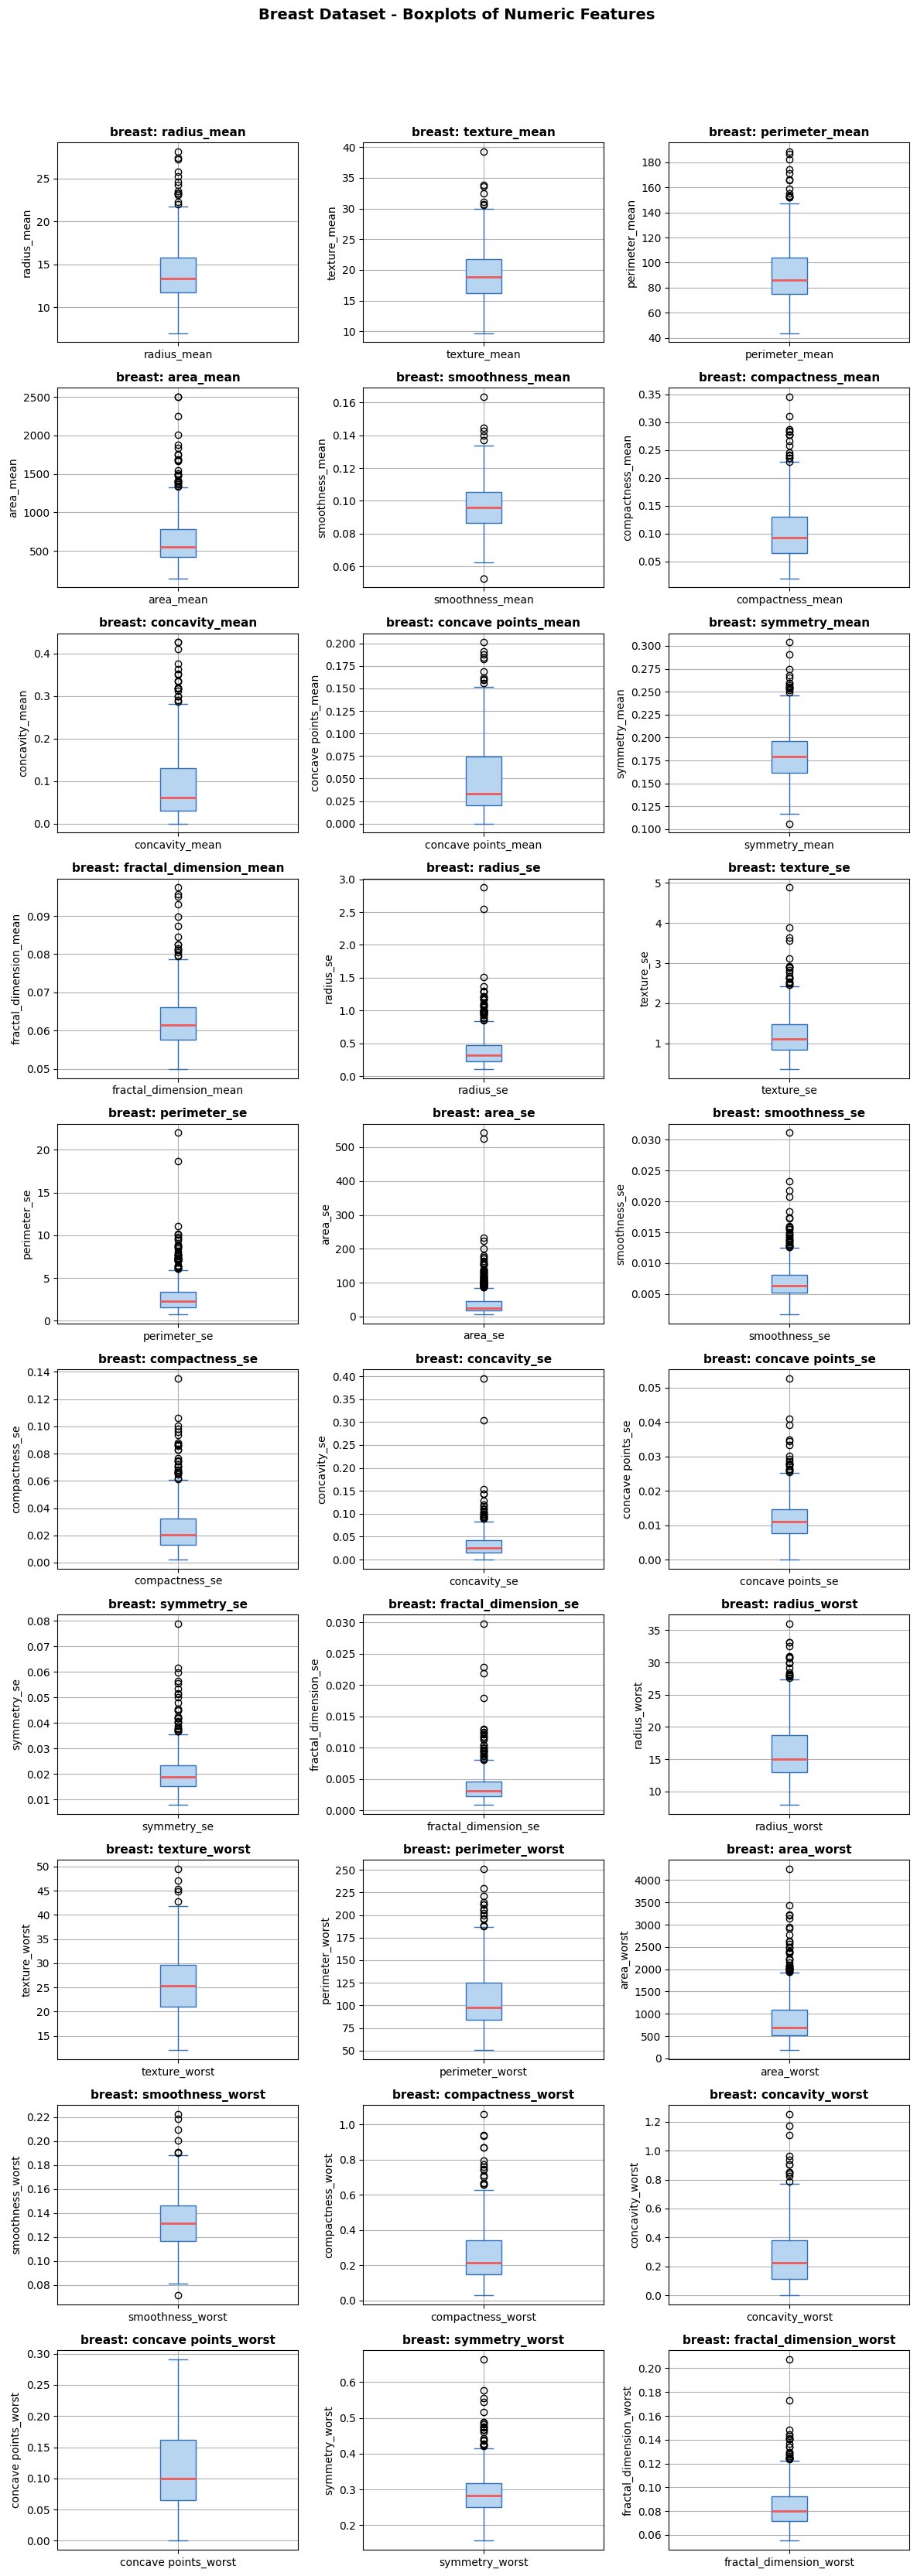

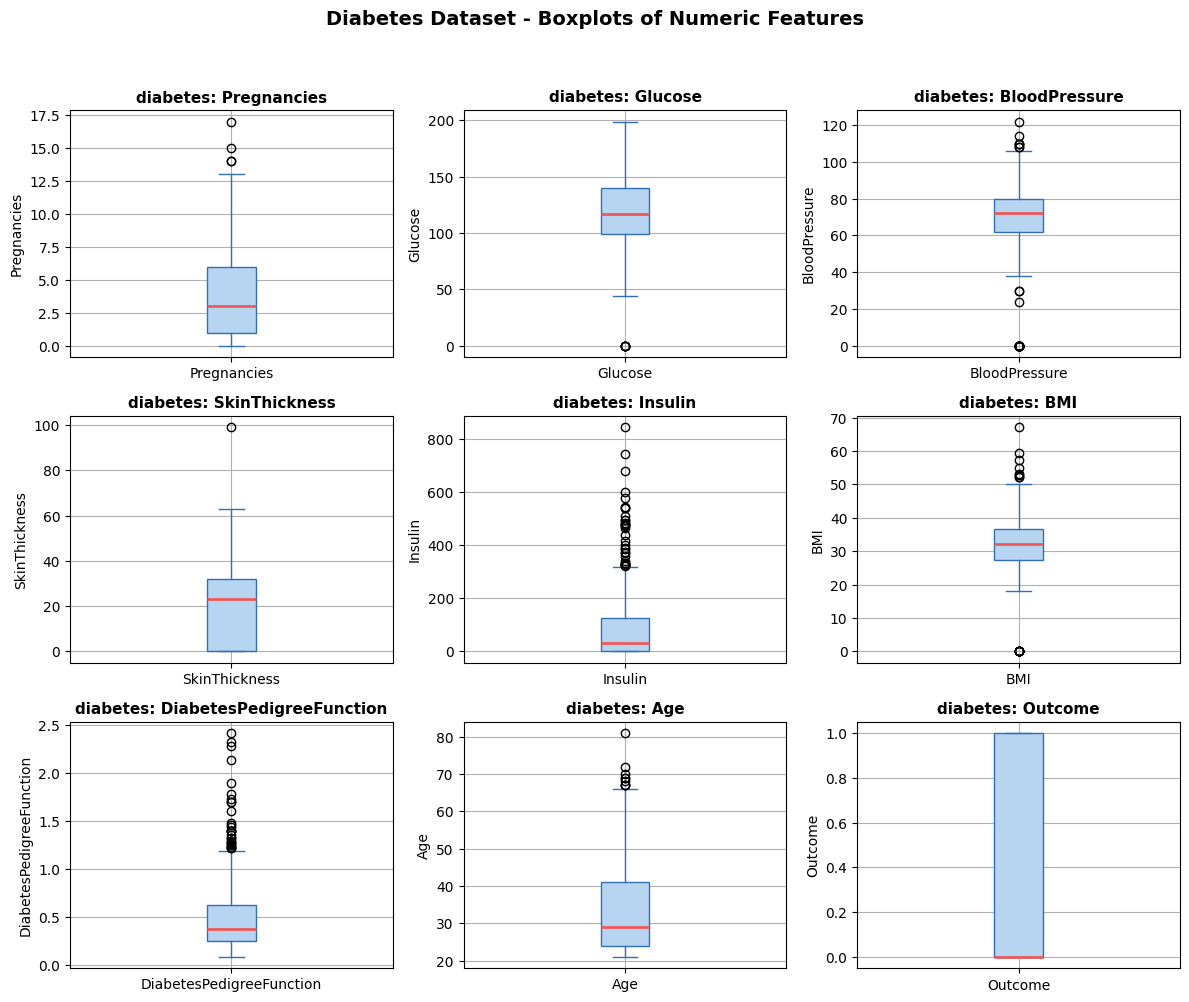

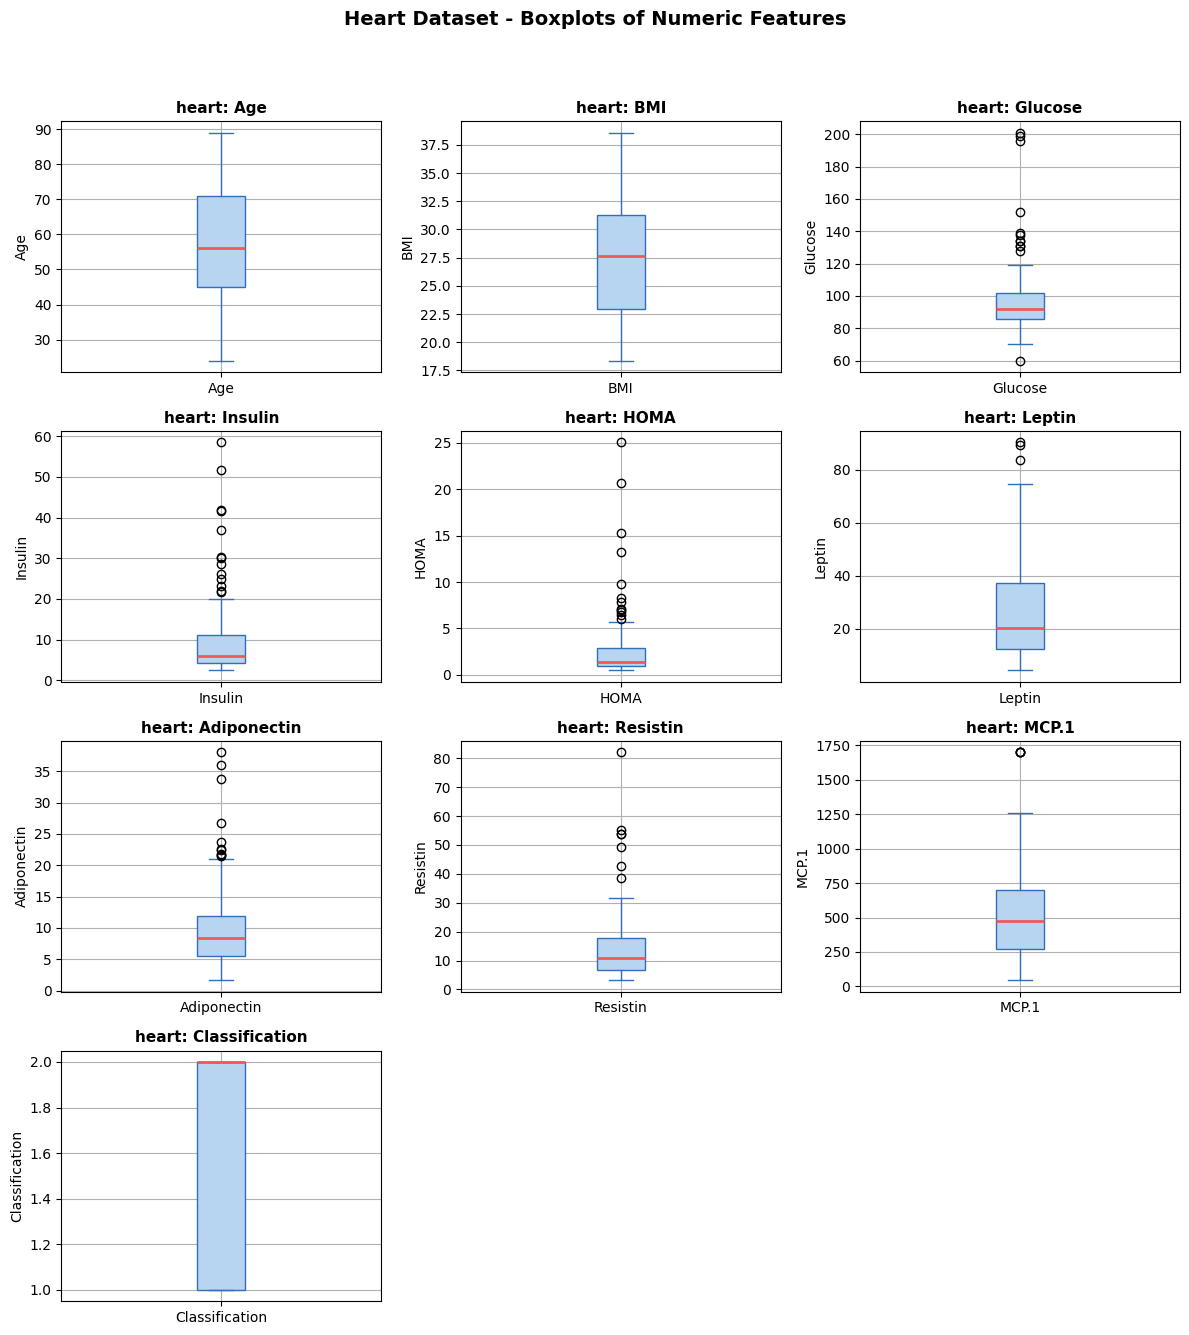

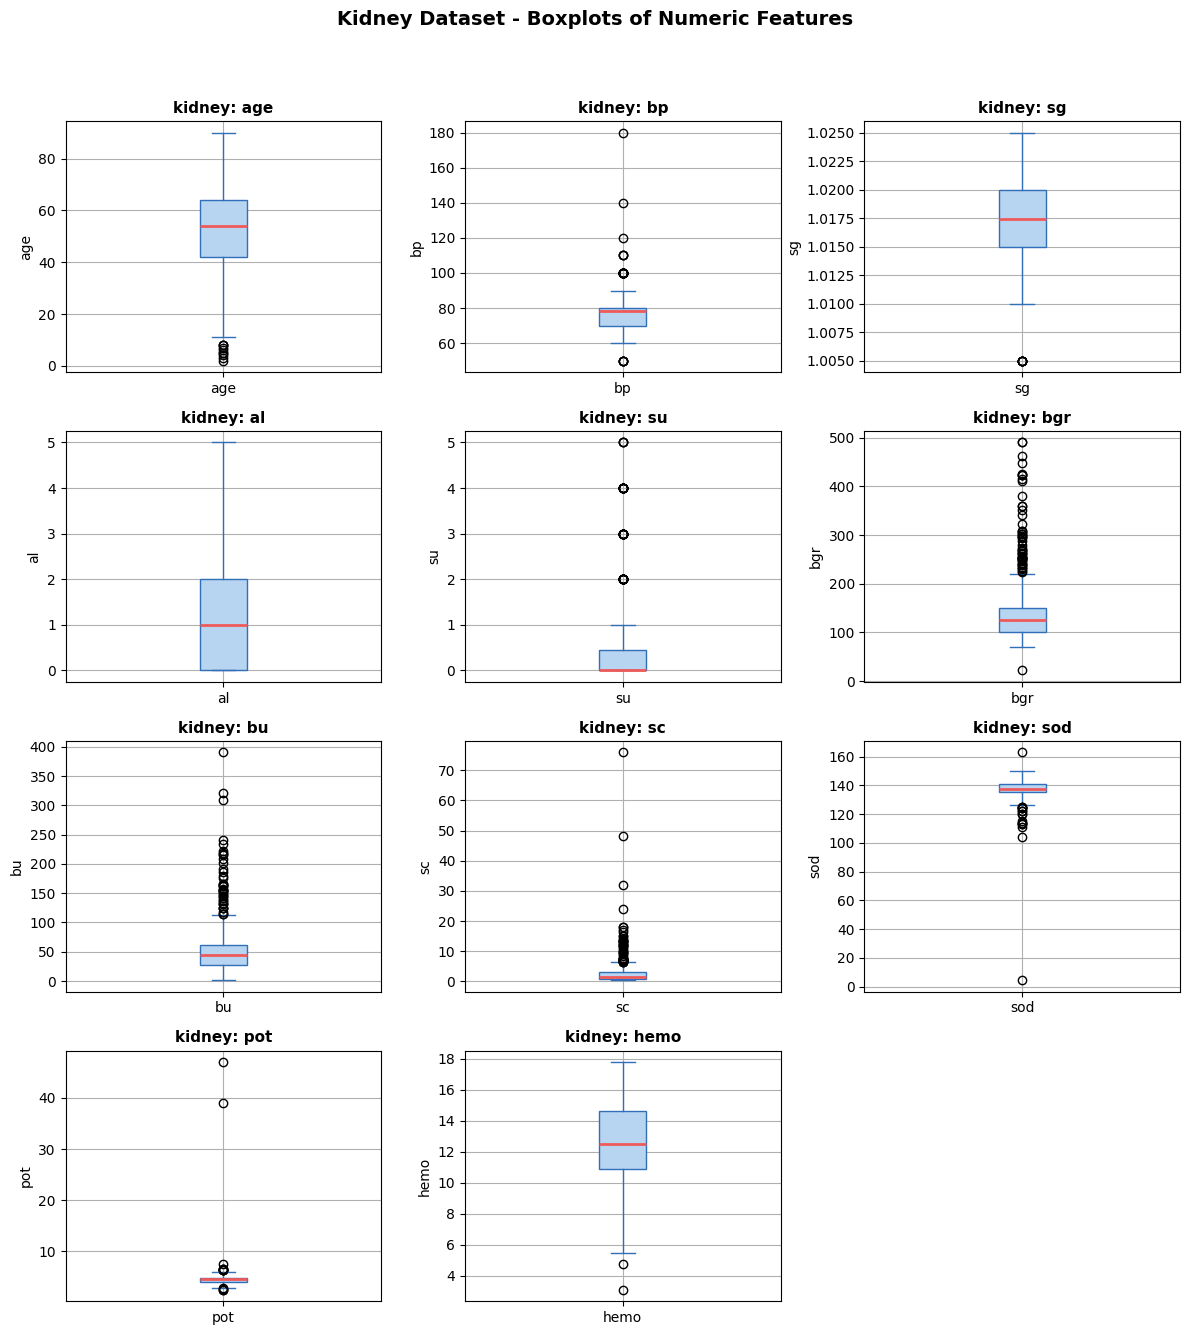

In [20]:
# boxplot visualization
for k in ["breast", "diabetes", "heart", "kidney"]:
    df = dfs[k]
    num_cols = df.select_dtypes(include=[np.number]).columns
    num_cols = [c for c in num_cols if c.lower() not in ["id", "unnamed: 32"]]
    
    if not num_cols:
        print(f"{k}: no numeric columns to plot.")
        continue
    
    ncols = 3
    nrows = int(np.ceil(len(num_cols) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3.5 * nrows))
    axes = np.array(axes).reshape(-1)
    
    for i, col in enumerate(num_cols):
        ax = axes[i]
        df.boxplot(column=col, ax=ax, patch_artist=True,
                   boxprops=dict(facecolor="#b7d4f0", color="#3170b8"),
                   medianprops=dict(color="#f05959", linewidth=2),
                   whiskerprops=dict(color="#3170b8"),
                   capprops=dict(color="#3170b8"))
        ax.set_title(f"{k}: {col}", fontsize=11, fontweight='bold')
        ax.set_xlabel("")  # Boxplot has category on x, but here we only plot one variable
        ax.set_ylabel(col)
    
    for j in range(i+1, nrows * ncols):
        axes[j].set_visible(False)
    
    fig.suptitle(f"{k.capitalize()} Dataset - Boxplots of Numeric Features", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
